In [39]:
import pickle
import pandas as pd
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import warnings
from IPython.display import Image
warnings.filterwarnings('ignore')


def emotion_over_year(year):
    """
    parameter:year:2015-2020
    output:labels of emotion, and the count of these emotions
    """
    with open(str(year)+'.pkl','rb') as file:
        dist = pickle.load(file)
    # the number of emotion negative
    count_negative=0
    for key in dist['nationality'][-1]:
        count_negative+=dist['nationality'][-1][key]

    # the number of emotion positive
    count_positive=0
    for key in dist['nationality'][1]:
        count_positive+=dist['nationality'][1][key]
    # the number of emotion positive
    count_mixture=2
    for key in dist['nationality'][2]:
        count_mixture+=dist['nationality'][2][key]

    count_neutral=0
    for key in dist['nationality'][0]:
        count_neutral+=dist['nationality'][0][key]


    labels = ['negative','positive','mixture','neutral']
    values = [count_negative, count_positive, count_mixture, count_neutral]
    return labels,values


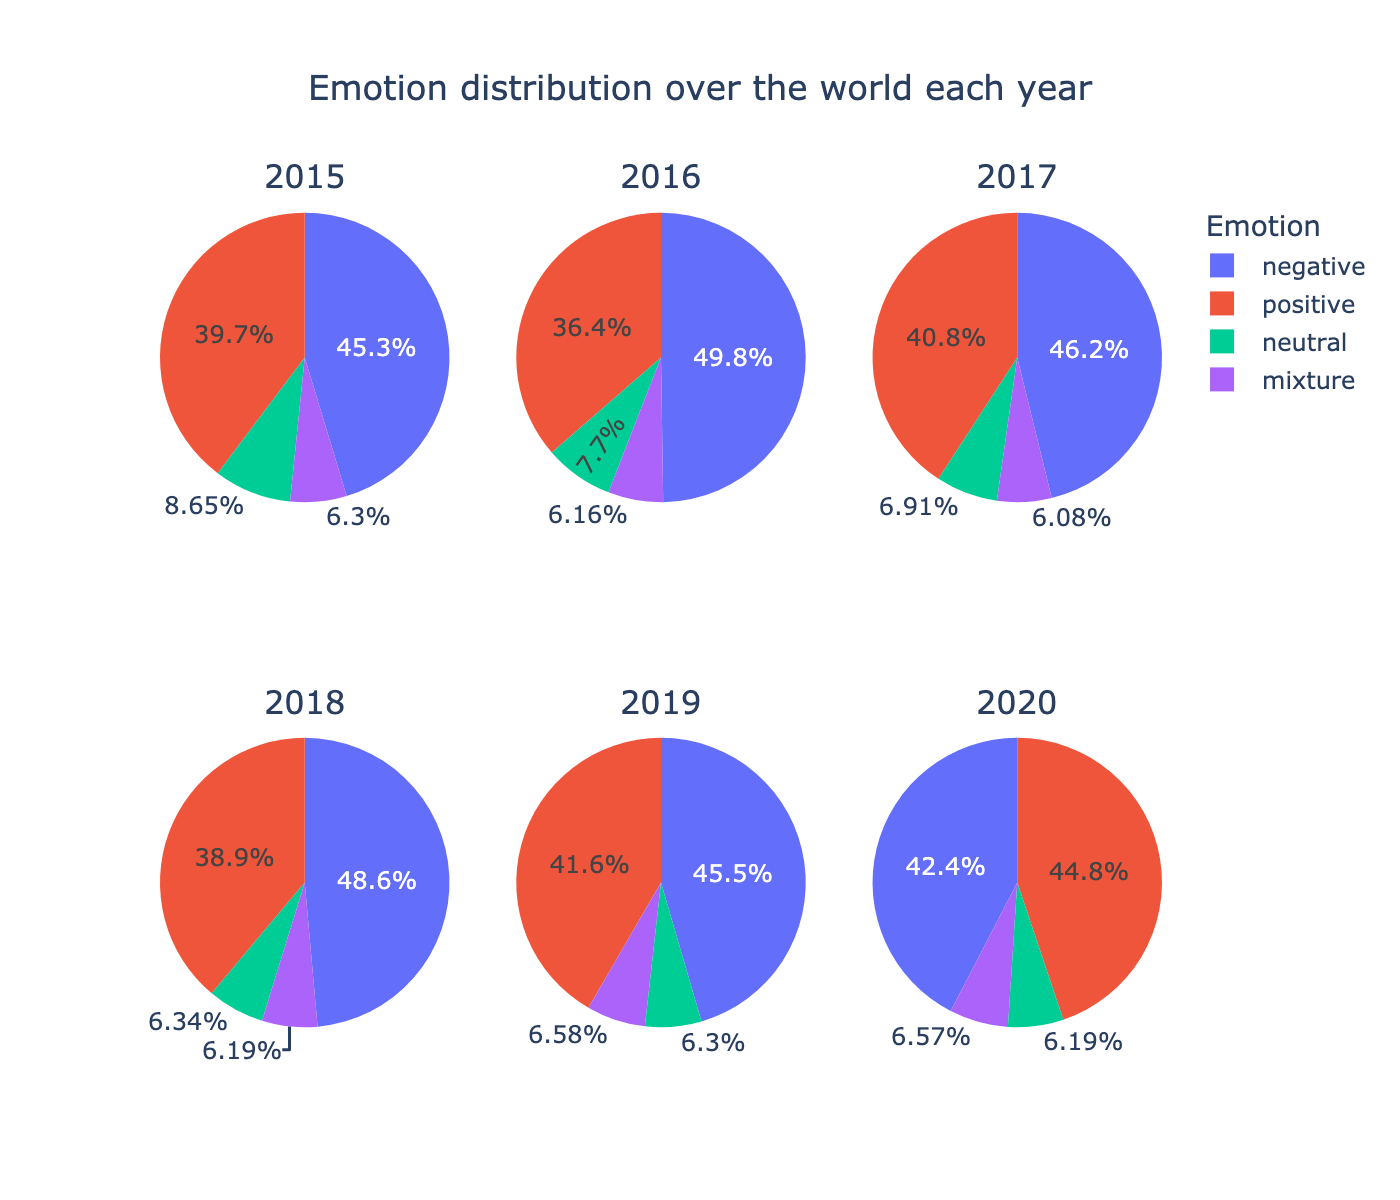

In [40]:
#This part is to analyse the trend of emotion distribution of the whole dataset, we use subplots to plot emotion distribution of all years in one image
fig=make_subplots(rows=2,cols=3,subplot_titles=("2015","2016","2017","2018","2019","2020"),specs=[[{'type':'pie'},{'type':'pie'},{'type':'pie'}],[{'type':'pie'},{'type':'pie'},{'type':'pie'}]])
labels, values=emotion_over_year(2015)
fig.append_trace(go.Pie(labels=labels, values=values,name=2015),row=1,col=1)
labels, values=emotion_over_year(2016)
fig.append_trace(go.Pie(labels=labels, values=values,name=2016),row=1,col=2)
labels, values=emotion_over_year(2017)
fig.append_trace(go.Pie(labels=labels, values=values,name=2017),row=1,col=3)
labels, values=emotion_over_year(2018)
fig.append_trace(go.Pie(labels=labels, values=values,name=2018),row=2,col=1)
labels, values=emotion_over_year(2019)
fig.append_trace(go.Pie(labels=labels, values=values,name=2019),row=2,col=2)
labels, values=emotion_over_year(2020)
fig.append_trace(go.Pie(labels=labels, values=values,name=2020),row=2,col=3)
#Adjusting the format of the figure
width=700
height = 600
fig.update_layout(
    title_text='Emotion distribution over the world each year',
    title_x=0.5,
    width=width,
    height=height,
    legend_title="  Emotion"
)
fig.write_html('emotion distribution over the world each year.html')
fig.write_image('Emotion distribution over the world each year.png', scale=2)

Image('Emotion distribution over the world each year.png')



From the Pie graph of emotion distribution around the world, we can find the proportion of negative attitudes towards LGBTQ is always higher than the proportion of positive attitudes, which means most people in the world still cannot accept this minority group. However, from 2018 to 2020, the proportion of negative attitudes towards LGBTQ is decreasing while the proportion of positive attitudes towards LGBTQ is increasing, it shows that the acceptance level about LGBTQ is increasing in recent year, which is definitely a good sign towards LGBTQ group.

# the variance of trend of attention over year

In [41]:
def change_the_type(x):
    """
    This function is used to change the type of input into float, which is used in the dataframe.apply
    """
    return float(x)

In [126]:
def attention_trend_by_feature(feature):
    """
    This function is used to analyse the attention trend of different group after choosing the feature
    """
    
    Year=[2015,2016,2017,2018,2019,2020]

    Data=pd.DataFrame(columns=['year',feature,'positive','negative','neutral','mixture','sum'])
    for year in Year:
        #import the file
        with open(str(year)+'.pkl','rb') as file:
            dist = pickle.load(file)

        data_positive=pd.DataFrame.from_dict([dist[feature][1]]).T
        data_positive=data_positive.reset_index()
        data_positive.columns=[feature,'positive']
        data_negative=pd.DataFrame.from_dict([dist[feature][-1]]).T
        data_negative=data_negative.reset_index()
        data_negative.columns=[feature,'negative']
        data_neutral=pd.DataFrame.from_dict([dist[feature][0]]).T
        data_neutral=data_neutral.reset_index()
        data_neutral.columns=[feature,'neutral']
        data_mixture=pd.DataFrame.from_dict([dist[feature][2]]).T
        data_mixture=data_mixture.reset_index()
        data_mixture.columns=[feature,'mixture']

        data=pd.merge(data_positive,data_negative,how='left',on=feature)
        data=pd.merge(data,data_neutral,how='left',on=feature)
        data=pd.merge(data,data_mixture,how='left',on=feature)
        data=data.fillna(0)
        data['sum']=data.sum(axis=1)
        data['relative_number']=data['sum']/data['sum'].sum()
        #change the content of date of birth into the young, middle, old
        if feature=='date_of_birth':
            for i in range(len(data)):
                if int(data['date_of_birth'][i])>=1990:
                    data['date_of_birth'][i]='1990-'

                elif int(data['date_of_birth'][i])>=1960:
                    data['date_of_birth'][i]='1960-1989'

                else:
                    data['date_of_birth'][i]='<1959'
            data=data.groupby('date_of_birth').sum()
            data=data.reset_index()
            #put all the other gender into a group LGBTQ
        if feature=='gender':
            for i in range(len(data)):

                if data['gender'][i]=='cisgender female' or data['gender'][i]=='female':
                    data['gender'][i]='female'
                elif data['gender'][i]=='cisgender male' or data['gender'][i]=='male':
                    data['gender'][i]='male'
                else:
                    data['gender'][i]='LGBTQ'
            data=data.groupby('gender').sum()
            data=data.reset_index()
            #merge the movie actor, television actor into actor
        if feature=='occupation':
            for i in range(len(data)):

                if data['occupation'][i]=='film actor' or data['occupation'][i]=='television actor':
                    data['occupation'][i]='actor'

            data=data.groupby('occupation').sum()

            data=data.reset_index()
        data['year']=year

        if feature!='gender' and feature!='date_of_birth':
            data=data.sort_values(by='sum',ascending=False)


        Data=pd.concat([Data,data])
    Data=Data.reset_index(drop=True)
    Data['positive']=Data['positive'].apply(change_the_type)
    top=Data.groupby(feature).sum().sort_values('sum',ascending=False)[0:10].index.to_list()
    Data=Data[Data[feature].isin(top)]
    for i in Year:
        
        Data[Data['year']==i]['relative_number']=Data[Data['year']==i]['relative_number']/Data[Data['year']==i]['relative_number'].sum()
    return Data





In [242]:
#plot the attention trend based on feature['date_of_birth', 'nationality', 'gender', 'ethnic_group', 'occupation', 'religion']
feature='religion'
fig=go.Figure()
Data=attention_trend_by_feature(feature)

# fig = px.bar(Data, x='year', y='relative_number',color=feature,width=850,height=700, title=feature+' top10 distribution')
for i in set(Data[feature]):

    fig.add_trace(go.Scatter(x=Data[Data[feature]==i]['year'], y=Data[Data[feature]==i]['relative_number'],mode='lines',name=i))
#Adjusting the format of the figure
fig.update_traces(overwrite=True, stackgroup='one')
width=700
height = 500
fig.update_layout(
    title_text='Attention trend of different groups',
    title_x=0.25,
    title_y=0.85,
    width=width,
    height=height,
    legend_title="  "+feature,
    xaxis_title="Year",
    yaxis_title="Group attention Percentage (%)",

    
)

# fig.update_layout(legend=dict(
#     orientation="h",  # 开启水平显示
#     yanchor="bottom",
#     y=-0.5,
#     xanchor="right",
#     x=1
# ))
fig.write_image(feature+' Attention trend of different groups.png', scale=2)
fig.show()
fig.write_html(feature+' Attention trend of different groups.html')
# Image('Attention trend of different groups.png')

#plot the attention trend based on feature['date_of_birth', 'nationality', 'gender', 'ethnic_group', 'occupation', 'religion']

# Image('Attention trend of different groups.png')

In this section, we will first divide the people into different groups by setting the features we want to analyse(age, nationality, gender, ethnic_group, occupation, religion), and then we will focus on the trend of their attention by year.

Firstly, we set the feature as age, and divide all the people into 3 groups, the person who was born after 1990 called young, the person whose birth between 1960-1989 called medium, the person who was born before 1959 called old, and we find that medium group pays most attention in the LGBTQ topic than the other, and the proportion of them is increasing by year. This happens, because this group represents the power center in the world, they are in charge of different area, therefore, it is their responsibilities to pay attention this sensitive topic and make or modify the law about LGBTQ.

Secondly, we focus on the nationality, first we find the people from US and UK pay most attention to this topic, and when we look at the trend in logy-x, we find that the people from US, UK, Canada, Australia, India pay most attention to this topic.

Thirdly, we focus the gender feature, in wikipedia, there are too many labels about gender, like bigender, non-bigender, genderfluid, transgendermale, transgenderfemale and so on, but the number of these people are so small to analyse, therefore, we put these people into a new group called LGBTQ, and then we analyse the male, female and LGBTQ these 3 groups. 
From the graph we can find the male group pays most attention to this topic, then female. However, another important phenomenon we find is even we put all the LGBTQ people into one group, the proportion of them is still less than 5%.

Fourthly, let's focus on the ethic group, and we find that African Americans pay most attention in this topic, and overpass the other group so much. This happens maybe because African Americans group face unequal treatment in the US than American Jews and White American.

Fifth，let's focus on the occupation feature, we find the politician pay most attention to this topic, this happens because they should consider the legislation related to this minority group in their country. Then the actor(include film and television actor) pay second most attention to this topic.

Finally, we focus on the religion feature, the top 2 groups are Catholic church and Judaism.


# Feature analysis towards different emotions

In [219]:
def emotion_distribution_analysis(feature):
    """
    This function is used to analyse the emotion distribution of different groups after choosing the feature
    """
    Year=[2015,2016,2017,2018,2019,2020]
    Data=pd.DataFrame(columns=['year',feature,'positive','negative','neutral','mixture','sum'])
    #import all the files over year
    for year in Year:
        with open(str(year)+'.pkl','rb') as file:
            dist = pickle.load(file)

        data_positive=pd.DataFrame.from_dict([dist[feature][1]]).T
        data_positive=data_positive.reset_index()
        data_positive.columns=[feature,'positive']
        data_negative=pd.DataFrame.from_dict([dist[feature][-1]]).T
        data_negative=data_negative.reset_index()
        data_negative.columns=[feature,'negative']
        data_neutral=pd.DataFrame.from_dict([dist[feature][0]]).T
        data_neutral=data_neutral.reset_index()
        data_neutral.columns=[feature,'neutral']
        data_mixture=pd.DataFrame.from_dict([dist[feature][2]]).T
        data_mixture=data_mixture.reset_index()
        data_mixture.columns=[feature,'mixture']

        data=pd.merge(data_positive,data_negative,how='left',on=feature)
        data=pd.merge(data,data_neutral,how='left',on=feature)
        data=pd.merge(data,data_mixture,how='left',on=feature)
        data=data.fillna(0)
        data['sum']=data.sum(axis=1)
        #change the content of date of birth into the young, middle, old
        if feature=='date_of_birth':
            for i in range(len(data)):
                if int(data['date_of_birth'][i])>=1990:
                    data['date_of_birth'][i]='1990-'

                elif int(data['date_of_birth'][i])>=1960:
                    data['date_of_birth'][i]='1960-1989'

                else:
                    data['date_of_birth'][i]='<1959'
            data=data.groupby('date_of_birth').sum()
            data=data.reset_index()
        #merge the movie actor, television actor into actor
        if feature=='occupation':
            for i in range(len(data)):

                if data['occupation'][i]=='film actor' or data['occupation'][i]=='television actor':
                    data['occupation'][i]='actor'

            data=data.groupby('occupation').sum()

            data=data.reset_index()
        #put all the other gender into a group LGBTQ
        if feature=='gender':
            for i in range(len(data)):
                if data['gender'][i]=='cisgender female' or data['gender'][i]=='female':
                    data['gender'][i]='female'
                elif data['gender'][i]=='cisgender male' or data['gender'][i]=='male':
                    data['gender'][i]='male'
                else:
                    data['gender'][i]='LGBTQ'
            data=data.groupby('gender').sum()

            data=data.reset_index()
        data['year']=year

        if feature!='gender' and feature!='date_of_birth':
            data=data.sort_values(by='sum',ascending=False)
            data=data.reset_index(drop=True)
            data=data[0:10]
        data['positive%']=data['positive']/data['sum']
        data['negative%']=data['negative']/data['sum']
        data['neutral%']=data['neutral']/data['sum']
        data['mixture%']=data['mixture']/data['sum']


        Data=pd.concat([Data,data])
    Data=Data.reset_index(drop=True)
    Data['positive']=Data['positive'].apply(change_the_type)
    Data1=pd.DataFrame(columns=['year',feature,'count','proportion','emotion'])
    for i in range(len(Data)):
        a=Data[['year',feature,'positive','positive%']].iloc[i]
        a['emotion']='positive'
        Data1=Data1.append([{'year':a['year'],feature:a[feature],'count':a['positive'],'proportion':a['positive%'],'emotion':a['emotion']}])
        a=Data[['year',feature,'negative','negative%']].iloc[i]
        a['emotion']='negative'
        Data1=Data1.append([{'year':a['year'],feature:a[feature],'count':a['negative'],'proportion':a['negative%'],'emotion':a['emotion']}])
        a=Data[['year',feature,'neutral','neutral%']].iloc[i]
        a['emotion']='neutral'
        Data1=Data1.append([{'year':a['year'],feature:a[feature],'count':a['neutral'],'proportion':a['neutral%'],'emotion':a['emotion']}])
        a=Data[['year',feature,'mixture','mixture%']].iloc[i]
        a['emotion']='mixture'
        Data1=Data1.append([{'year':a['year'],feature:a[feature],'count':a['mixture'],'proportion':a['mixture%'],'emotion':a['emotion']}])

    Data1=Data1.reset_index(drop=True)
    

    fig = px.bar(Data1, x=feature, y='proportion',color='emotion',text='count',width=850,height=700, title=feature+' top10 distribution',animation_frame='year')
    #Adjusting the format of the figure
    width=600
    height = 550
    fig.update_layout(
        title_text='Emotion distribution of different groups',
        title_x=0.5,
        width=width,
        height=height,
        legend_title="  Emotion"
    )
    fig.update_layout(legend=dict(
    orientation="h",  # 开启水平显示
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=1
))
    fig.write_image('Emotion distribution of different groups.png', scale=2)
    fig.write_html(feature+' Emotion distribution of different groups.html')
    fig.show()
    


In [226]:
#plot the emotion distribution based on feature['date_of_birth', 'nationality', 'gender', 'ethnic_group', 'occupation', 'religion']
feature= 'religion'
emotion_distribution_analysis(feature)

# Image('Emotion distribution of different groups.png')


In this section we focus on the emotion distribution in each group, and also analyse attitude evolution by year.

To begin with, we will introduce how to read this graph. The title of x means the feature we choose(date_of birth, gender, nationality and so on), each bar means one group divided by this feature, if the group number is more than 10, we will just choose the most representative top 10 for our analysis, the title of y means the proportion of each emotion in this group, the number inside in each bar means the number of people who have such emotion in the group. Final part of this graph is slider, we can analyse the emotion distribution in different year. Then we can start our analysis.

Firstly, we will analyse the emotion distribution in different ages, we can see that the young people have the most positive attitudes towards LGBTQ, which means they have tolerant attitudes towards this minority group, this is obviously a good sign for the development of LGBTQ, because in the future, these young people will become the essential people in different areas, who will have the power to improve the development of the LGBTQ.

Secondly, we will analyse the emotion distribution in different nationalities, and then we can find some interesting facts, the people from Israel usually have the negative attitudes towards the LGBTQ, while Ireland people usually have the positive attitude towards LGBTQ. And then we focus the Top3 country with most attention, that is US, UK, Canada, we can find that in US, negative emotion is usually overpass the positive emotion. In UK, the proportion of positive emotion is increasing by year. In Canada, the negative emotion proportion and positive emotion proportion are close.

Thirdly, we will focus on the gender feature, we can find that there are no significant relationship between emotion and gender, because in all group, the negative emotion ratio overpasses or equals to the positive emotion ratio. Although in 2020, the female have more positive emotion than negative emotion, the sample size of 2020 is smaller than the other years. Therefore, this result may be not so precise.

Fourthly, we will focus on the ethic feature, given that the data size in most groups are small, so we just focus on the African American and Jewish people. We can find that there are no significant relationship between emotion and ethic group, because the negative emotion ratio usually overpass the positive emotion ratio.

Fifthly, we will focus on the occupation feature, and we can find some interesting facts, most politicians, writers, lawyers and journalists have negative emotions towards LGBTQ, while the people whose job is related to TV or film, like actor, singer, film producer and so on. usually have positive attitudes towards LGBTQ.

Finally, let's focus on the religion, and let's just focus on the Judaism and Catholic Church, we will find that the negative emotion ratio is so large in these 2 groups, for example in 2017, the negative emotion ratio is 70%, which is more than the average negative emotion ratio(46.2%)
